# Preliminaries

In [1]:
import os
import sys

import yaml

from PIL import Image

import numpy as np
import torch
import torchvision.transforms as T

from dataset import set_global_seed

from dm import Unet, GaussianDiffusion, Trainer
from random_diffusion import RandomDiffusion
from random_diffusion_masks import RandomDiffusionMasks

import importlib
import dm_masks
importlib.reload(dm_masks)

from dm_masks import Unet as MaskUnet
from dm_masks import GaussianDiffusion as MaskGD
from dm_masks import Trainer as MaskTrainer
from utils.mask_modules import CleanMask

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
@torch.no_grad()
def sample(masks, cond_scale=3.0):
    z = torch.ones((masks.shape[0],
                    4,512//8,512//8), device='cuda:0')
    z = trainer.ema.ema_model.sample(z,masks, cond_scale=cond_scale+1)*50
    return torch.clip(trainer.vae.decode(z).sample,0,1)

# Load Mask Generation Model

In [3]:
milestone=5
config_file='./config/mask_gen_sample5.yaml'

with open(config_file, 'r') as config_file:
    config = yaml.safe_load(config_file)
for key in config.keys():
    globals().update(config[key])
    
maskunet = MaskUnet(
        dim=dim,
        num_classes=num_classes,
        dim_mults=dim_mults,
        channels=channels,
        resnet_block_groups = resnet_block_groups,
        block_per_layer=block_per_layer,
    )

maskmodel = MaskGD(
        maskunet,
        image_size=mask_size//8,
        timesteps=timesteps,
        sampling_timesteps=sampling_timesteps,
        loss_type='l2')

masktrainer = MaskTrainer(
        maskmodel,
        train_batch_size=batch_size,
        train_lr=lr,
        train_num_steps=train_num_steps,
        save_and_sample_every=save_sample_every,
        gradient_accumulate_every=gradient_accumulate_every,
        save_loss_every=save_loss_every,
        num_samples=num_samples,
        num_workers=num_workers,
        results_folder=results_folder)

masktrainer.load(milestone)
masktrainer.ema.cuda()
masktrainer.ema=masktrainer.ema.eval()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

# Load Image Generation Model

In [4]:
milestone=10
config_file='./config/image_gen_sample5.yaml'

with open(config_file, 'r') as config_file:
    config = yaml.safe_load(config_file)
for key in config.keys():
    globals().update(config[key])

unet = Unet(
        dim=dim,
        num_classes=num_classes,
        dim_mults=dim_mults,
        channels=channels,
        resnet_block_groups = resnet_block_groups,
        block_per_layer=block_per_layer,
    )

model = GaussianDiffusion(
        unet,
        image_size=image_size//8,
        timesteps=timesteps,
        sampling_timesteps=sampling_timesteps,
        loss_type='l2')

trainer = Trainer(
        model,
        train_batch_size=batch_size,
        train_lr=lr,
        train_num_steps=train_num_steps,
        save_and_sample_every=save_sample_every,
        gradient_accumulate_every=gradient_accumulate_every,
        save_loss_every=save_loss_every,
        num_samples=num_samples,
        num_workers=num_workers,
        results_folder=results_folder)

trainer.load(milestone)
trainer.ema.cuda()
trainer.ema=trainer.ema.eval()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

# Toy Example Mask-Image Sampling

Visualising the class generation in sequence. This toy example shows DiffInfinite Mask-Image control. This output doesn't have biological meaning and it isn't accurate because the generated class depends on the mask shape and its neighbours. The mask generation is necessary to give this spatial information.

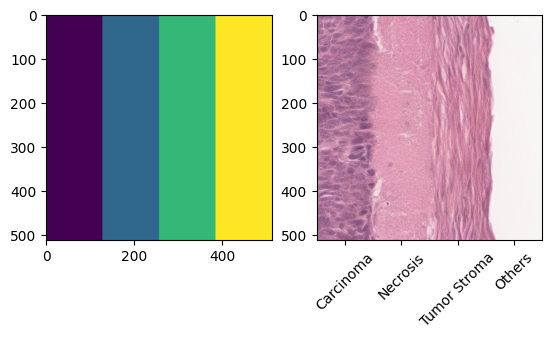

In [5]:
'''Strides Generation'''

classes_names = ['Carcinoma', 'Necrosis', 'Tumor Stroma', 'Others']

test_masks=torch.ones((1,1,512,512), device='cuda:0').int()

for i in range(len(classes_names)):
    test_masks[:,:,:,i*(512//len(classes_names)):(i+1)*(512//len(classes_names))]=i+1
    
outputs=sample(test_masks, cond_scale=3.0)

xtick_positions = [(512//(2*len(classes_names)))+(512//len(classes_names))*i for i in range(4)]

fig,ax=plt.subplots(ncols=2)
ax[0].imshow(test_masks[0,0].cpu())
ax[1].imshow(outputs[0].permute(1,2,0).cpu())
ax[1].set_xticks(xtick_positions, classes_names, rotation=45)
plt.show()

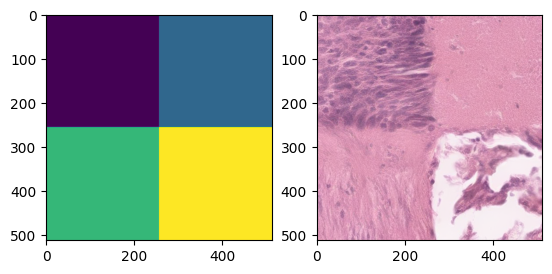

In [6]:
'''Squares Generation'''
    
test_masks=torch.ones((1,1,512,512), device='cuda:0').int()
test_masks[:,:,:512//2,:512//2]=1
test_masks[:,:,:512//2,512//2:]=2
test_masks[:,:,512//2:,:512//2]=3
test_masks[:,:,512//2:,512//2:]=4

outputs=sample(test_masks, cond_scale=3.0)

fig,ax=plt.subplots(ncols=2)
ax[0].imshow(test_masks[0,0].cpu())
ax[1].imshow(outputs[0].permute(1,2,0).cpu())
plt.show()

# Generate Images from Masks

We initially create a synthetic mask based on a contextual prompt, and then we use that mask as a guide to generate the corresponding image.

### Sample Masks

In [7]:
'''Mask Generation'''

n_batches = 2
batch_size = 2
sample_label = 1 # 0-> 'adenocarcinoma'; 1 -> 'squamouscarcinoma'; None -> use both labels

masks = masktrainer.sample_loop(n_batches, batch_size=batch_size, sample_label=sample_label, save_sample=False)

*_, h,w = masks.shape
masks = masks.reshape(-1, 1, h, w)

generate 4 masks using device=cuda
Sampling complete.


In [8]:
'''Image Generation'''
    
outputs=sample(masks.cuda(), cond_scale=3.0)

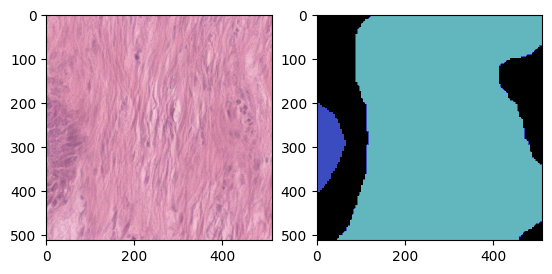

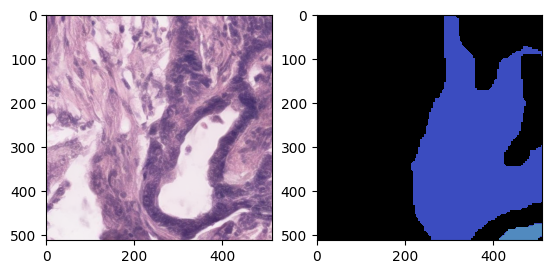

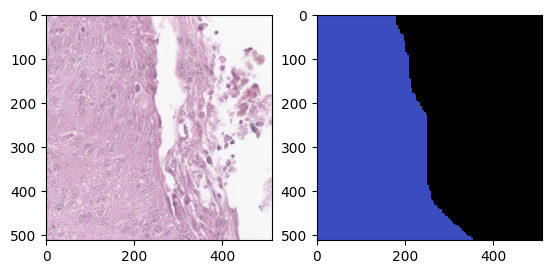

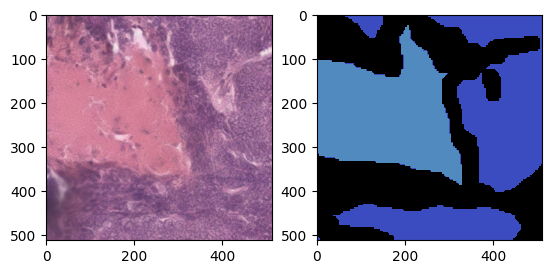

In [9]:
'''Visualise Synthetic Mask-Image pairs'''

colors = {0:'#000000', 1:'#3b4cc0', 2:'#518abf', 3:'#62b7bf', 4:'#71e3bd'}

for i in range(len(outputs)):
    fig,ax=plt.subplots(ncols=2)

    cmap = ListedColormap([colors[unique.cpu().item()] for unique in torch.unique(masks[i])])
    ax[0].imshow(outputs[i].permute(1,2,0).cpu().detach())
    im=ax[1].imshow(masks[i,0].cpu().detach(),cmap=cmap)

In [10]:
'''Image Generation for different omegas'''

cond_scales=[0.0,3.0,6.0]

outputs=[]
for cond_scale in cond_scales:
    set_global_seed(10)
    outputs.append(sample(masks[0][None].cuda(), cond_scale=cond_scale))
outputs=torch.cat(outputs,0)

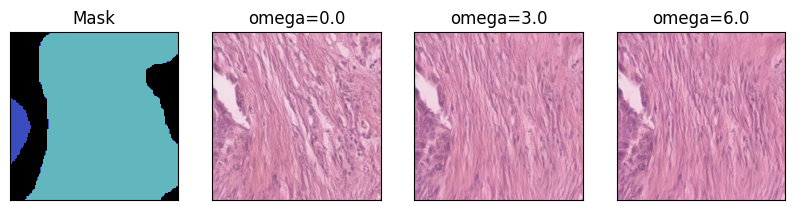

In [11]:
'''Visualise Synthetic Mask-Image pairs with different omegas'''

colors = {0:'#000000', 1:'#3b4cc0', 2:'#518abf', 3:'#62b7bf', 4:'#71e3bd'}

fig,ax=plt.subplots(ncols=len(cond_scales)+1, figsize=(10,10))
cmap = ListedColormap([colors[unique.cpu().item()] for unique in torch.unique(masks[0])])
ax[0].imshow(masks[0,0].cpu().detach(),cmap=cmap)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Mask')
for i in range(len(cond_scales)):
    ax[i+1].imshow(outputs[i].permute(1,2,0).cpu().detach())
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title(f'omega={cond_scales[i]}')

# Inpainting

Given image-mask pairs in the trainset, we inpaint a segmentated area with the same class showing that the model doesn't reproduce the same image.

In [12]:
files=os.listdir('./images/inpainting')
files.sort()
files=[file for file in files if file.endswith('.jpg')]

images,masks=[],[]
for file in files:
    image=np.array(Image.open(os.path.join('./images/inpainting',file)))
    mask=np.array(Image.open(os.path.join('./images/inpainting',file.replace('.jpg','_mask.png')))).astype(np.int32)
    
    mask[mask==4]=1
    mask[mask==7]=2
    mask[mask==8]=3
    mask[mask==9]=4
    
    image=torch.tensor(image).permute(2,0,1)[None]
    mask=torch.tensor(mask)[None,None]
    images.append(image)
    masks.append(mask)

images=torch.cat(images,0).cuda().float()/255
masks=torch.cat(masks,0).cuda().float()

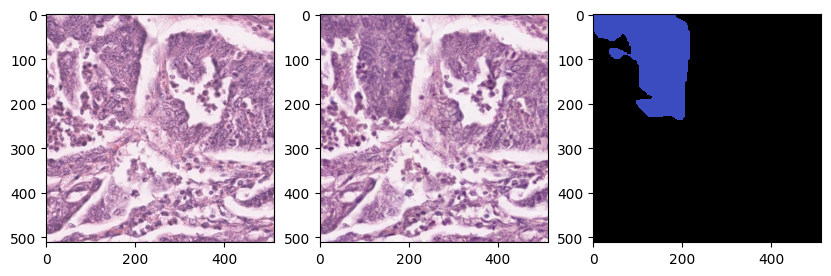

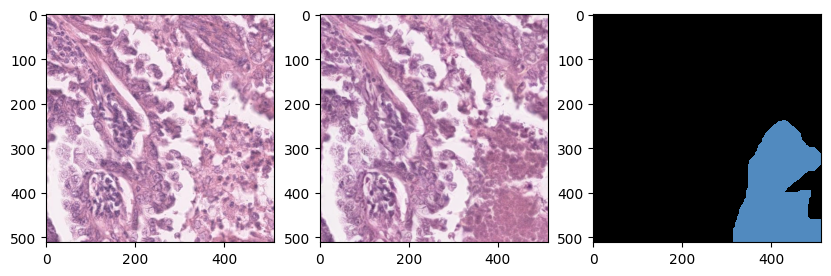

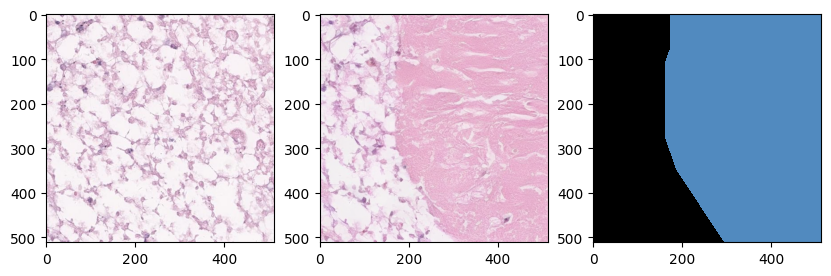

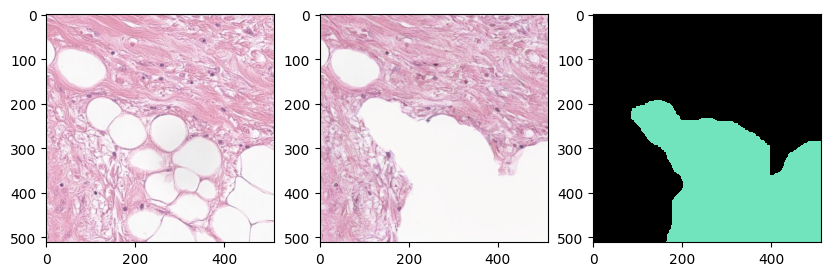

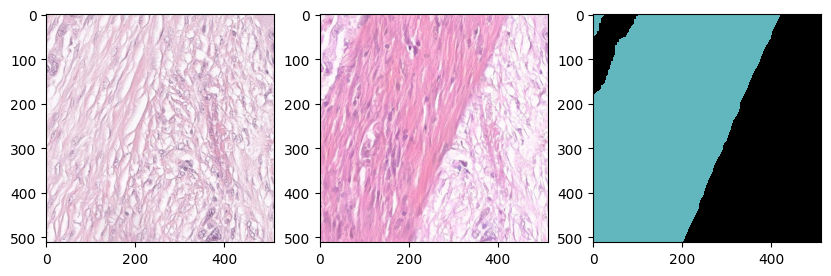

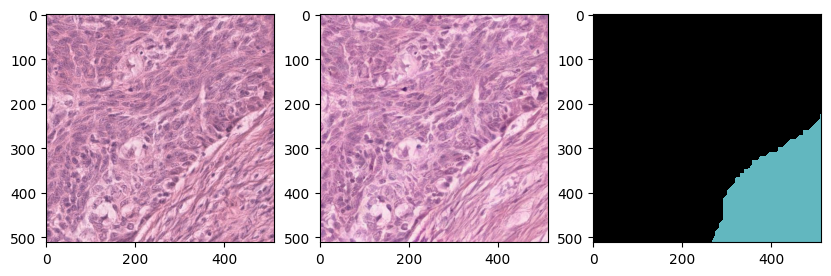

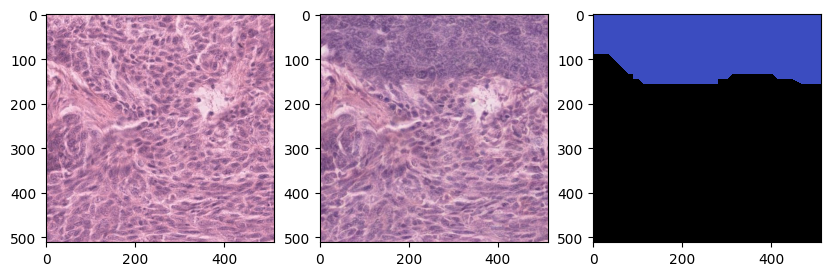

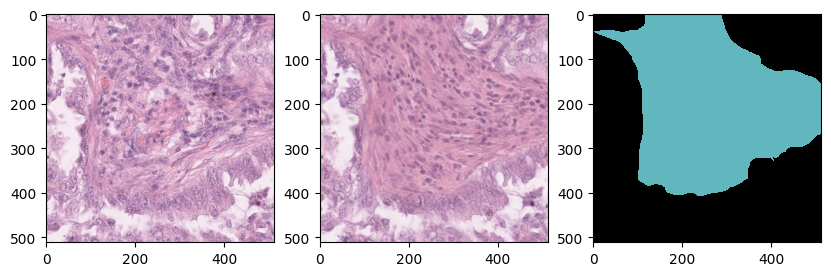

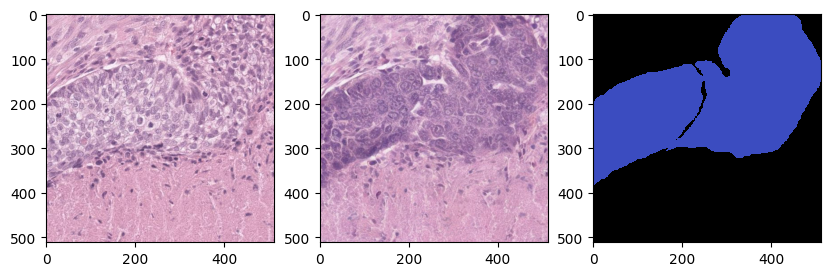

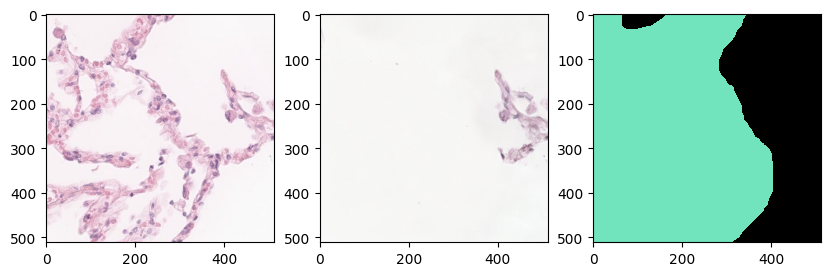

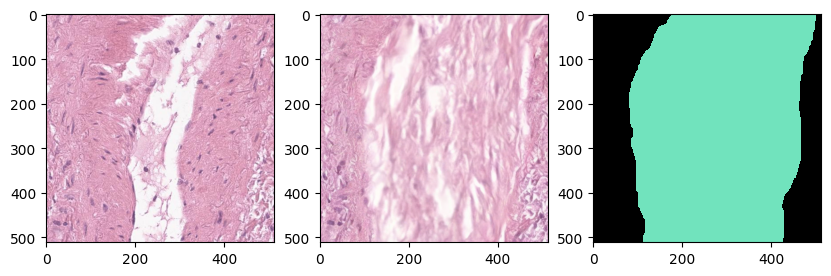

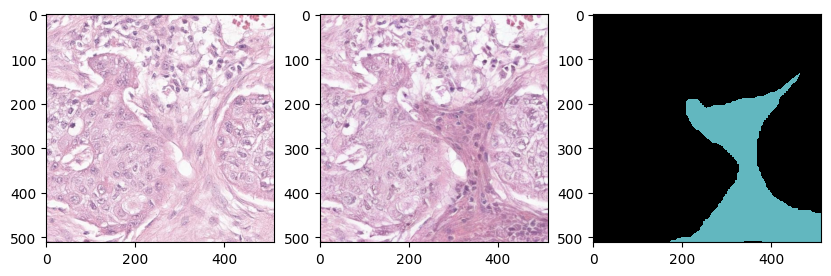

In [13]:
colors = {0:'#000000', 1:'#3b4cc0', 2:'#518abf', 3:'#62b7bf', 4:'#71e3bd'}

cond_scale=3.0

with torch.no_grad():
    z = trainer.vae.encode(images).latent_dist.sample()/50
    inp_mask=(torch.nn.functional.interpolate((masks>0).float(),(512//8,512//8))>0).float()
    z = trainer.ema.ema_model.sample(z, masks, inp_mask=inp_mask, cond_scale=cond_scale+1)*50
    inpainted=torch.clip(trainer.vae.decode(z).sample,0,1)

for i in range(len(images)):
    fig,ax=plt.subplots(ncols=3,figsize=(10,10))

    cmap = ListedColormap([colors[unique.cpu().item()] for unique in torch.unique(masks[i])])
    ax[0].imshow(images[i].permute(1,2,0).cpu().detach())
    ax[1].imshow(inpainted[i].permute(1,2,0).cpu().detach())
    im=ax[2].imshow(masks[i,0].cpu().detach(),cmap=cmap)

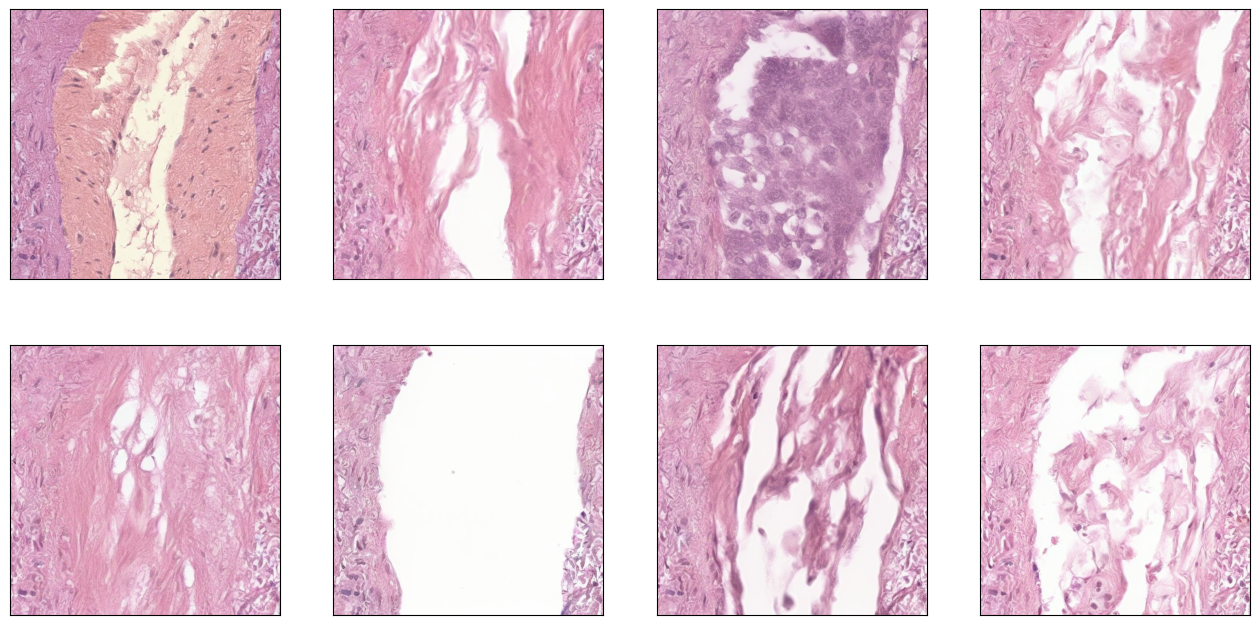

In [14]:
N=10
cond_scale=2.0
ncols=4
nrows=2

image=images[N][None]
mask=masks[N][None]

fig,ax=plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
ax[0,0].imshow(image[0].permute(1,2,0).cpu().detach())
ax[0,0].imshow(mask[0,0].cpu().detach(),alpha=0.1)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

image=image.repeat(7,1,1,1)
mask=mask.repeat(7,1,1,1)

with torch.no_grad():
    z = trainer.vae.encode(image).latent_dist.sample()/50
    inp_mask=(torch.nn.functional.interpolate((mask>0).float(),(512//8,512//8))>0).float()
    z = trainer.ema.ema_model.sample(z, mask, inp_mask=inp_mask, cond_scale=cond_scale+1)*50
    inpainted=torch.clip(trainer.vae.decode(z).sample,0,1)

for i in range(7):
    row=(i+1)//ncols
    col=(i+1)%ncols
    ax[row,col].imshow(inpainted[i].permute(1,2,0).cpu().detach())
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])

# Random Patch Diffusion

Given an existing mask, we use the random patch diffusion to generate a 2048x2048 image. In this instance, we chose a mask from the dataset that contains dense annotations, allowing us to demonstrate mask-image guidance control. It's important to note that most of the annotations in the dataset are sparse, similar to the mask that will be generated in the following section.

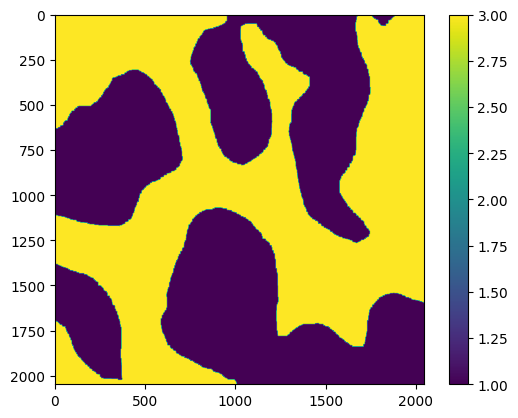

In [15]:
# Mask comparison

classes_names=['Unknown','Carcinoma','Necrosis','Tumor Stroma','Others']

mask=torch.tensor(np.array(Image.open('images/large-content/squamous_mask_example_5classes.png')))[None,None].float()
mask=torch.round(mask*(len(classes_names)-1)/255).int()[...,:2048,:2048]

plt.imshow(mask[0,0])
plt.colorbar()

In [16]:
random_sample = RandomDiffusion(
                        trainer,
                        patch_size=512, 
                        sampling_steps=250, 
                        cond_scale=0.0)
z = random_sample(mask)
img=random_sample.hann_tile_overlap(z)

 Generation 41.25%, indices=[0712:1224,0984:1496]

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(img[0].permute(1,2,0))

# Arbitrarely Large Mask-Image Generation
First generate a mask with the random patch diffusion method. Second, given the generated mask, we generate an image.

In [ ]:
image_size=2048
num_classes=5
labels=[1,] # 0-> 'adenocarcinoma'; 1 -> 'squamouscarcinoma'

masks=torch.cat([torch.ones((1,1,image_size//4,image_size//4))*label for label in labels], 0)

random_sample = RandomDiffusionMasks(
                        masktrainer,
                        patch_size=128, 
                        sampling_steps=250, 
                        cond_scale=0.0)

zs = random_sample(masks.cuda())

mask_out=[]
for z in zs:
    mask = random_sample.hann_tile_overlap(z[None])
    mask = torch.round((num_classes - 1) * mask[0])
    mask = torch.round(torch.mean(mask, axis=0, keepdim=True)) / (num_classes - 1)
    mask_upsampled = CleanMask(num_labels=num_classes,ups_mask_size=image_size)(mask)
    mask = T.ToTensor()(mask_upsampled)[None]
    mask_out.append(mask)
masks=torch.cat(mask_out,0)

In [ ]:
for i,mask in enumerate(masks):
    plt.imshow(mask[0])
    plt.show()

In [ ]:
random_sample = RandomDiffusion(
                        trainer,
                        patch_size=512, 
                        sampling_steps=250, 
                        cond_scale=3.0)

zs = random_sample(masks.cuda())

imgs=[]
for z in zs:
    imgs.append(random_sample.hann_tile_overlap(z[None]))
imgs=torch.cat(imgs,0)

In [ ]:
for i,img in enumerate(imgs):
    plt.imshow(img[0].permute(1,2,0))
    plt.show()